In [1]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [2]:
import os
import cv2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from PIL import Image
import random
import seaborn as sns
import urllib.parse

In [3]:
# MATCHING THE EDGES TO FORM A WEB OF NODES AND EDGES
def build_graph_manually():
    G = nx.Graph()
    print("\nEnter edges in the format: source destination weight")
    print("Type 'done' when finished.\n")
    while True:
        line = input("Enter edge (source destination weight): ").strip()
        if line.lower() == 'done':
            break
        try:
            u, v, w = line.split()
            G.add_edge(u, v, weight=float(w))
        except ValueError:
            print("Invalid format. Use: Source destination weight")
    return G

In [4]:
# plot the graph that was entered manually
# Function to draw a basic graph with optional path highlighting
def draw_graph_manual(G, path=None):
    pos = nx.spring_layout(G, seed=42)
    edge_weights = nx.get_edge_attributes(G, 'weight')
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700, font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights)
    if path:
        path_edges = list(zip(path, path[1:]))
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=3)
    plt.title("Graph with all the provided paths")
    plt.show()
    return pos

In [5]:
# TO LEAD IMAGE FROM GIVEN ADRESS
# Load an image from local path or URL
def load_image(image_path):
    image_path = image_path.strip().strip('"\'')
    if urllib.parse.urlparse(image_path).scheme in ('http', 'https'):
        from io import BytesIO
        import requests
        response = requests.get(image_path)
        response.raise_for_status()
        return cv2.cvtColor(np.array(Image.open(BytesIO(response.content))), cv2.COLOR_RGB2BGR)
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")
    image = cv2.imread(image_path)
    if image is not None:
        return image
    return cv2.cvtColor(np.array(Image.open(image_path)), cv2.COLOR_RGB2BGR)


In [6]:
# PROCESS IMAGE USING CV2 
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    return gray, thresh


In [7]:
# FUNCTION TO DETECT THE NODES AND NAME WRITTEN INTO THEM
# Detect circles using Hough Circle Transform
def detect_circles_and_names(image, thresh):
    edges = cv2.Canny(thresh, 50, 150)
    circles = cv2.HoughCircles(
        edges,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=20,
        param1=50,
        param2=30,
        minRadius=10,
        maxRadius=50
    )
    centers_with_names = {}
    if circles is not None:
        for i, c in enumerate(np.uint16(np.around(circles))[0, :]):
            x, y, r = c[0], c[1], c[2]
            # Extract ROI for the circle and some surrounding area to capture the name
            roi = image[max(0, y - r - 10):min(image.shape[0], y + r + 10),
                        max(0, x - r - 10):min(image.shape[1], x + r + 10)]
            node_name = f'Node{i}'  # fails or finds nothing

            if roi.size > 0:
                # Perform OCR to read text within the ROI.
                # config='--psm 8 --oem 1' suggests a single word. Adjust if needed.
                text = pytesseract.image_to_string(roi, config='--psm 8 --oem 1')
                cleaned_text = text.strip()
                if cleaned_text:
                    node_name = cleaned_text  # Use the recognized text as the node name

            centers_with_names[node_name] = (x, y)
    return centers_with_names


In [8]:
# function to detect the lines from the input imAGE 
# Detect lines using Probabilistic Hough Line Transform
def detect_lines(thresh):
    edges = cv2.Canny(thresh, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(
        edges,
        1,
        np.pi/180,
        threshold=50,
        minLineLength=20,
        maxLineGap=10
    )
    return [((l[0][0], l[0][1]), (l[0][2], l[0][3])) for l in lines] if lines is not None else []


In [9]:
# read the text written inside Nodes
def get_text_on_line(image, p1, p2):
    x1, y1 = map(int, p1)
    x2, y2 = map(int, p2)
    min_x = min(x1, x2)
    max_x = max(x1, x2)
    min_y = min(y1, y2)
    max_y = max(y1, y2)
    padding = 5
    roi = image[max(0, min_y - padding):min(image.shape[0], max_y + padding),
                max(0, min_x - padding):min(image.shape[1], max_x + padding)]
    if roi.size > 0:
        text = pytesseract.image_to_string(roi, config='--psm 6 --oem 1 -c tessedit_char_whitelist=0123456789.')
        cleaned_text = ''.join(filter(str.isdigit, text))
        return float(cleaned_text) if cleaned_text else None
    return None


In [10]:
# detect the image after detecting the edge and node plot them together
def build_graph_from_image(image_path):
# Load an image from local path or URL
    original_image = load_image(image_path)
    if original_image is None:
        return None, None, None
    gray_image, thresh_image = preprocess_image(original_image)
# Detect circles using Hough Circle Transform
    centers_with_names = detect_circles_and_names(original_image.copy(), thresh_image.copy())
# Detect lines using Probabilistic Hough Line Transform
    lines = detect_lines(thresh_image)
    G = nx.Graph()

    if not centers_with_names:
        print("No circles detected in the image.")
        return G, {}, original_image

    node_positions = centers_with_names
    name_to_center = {name: center for name, center in centers_with_names.items()}
    centers = list(name_to_center.values())
    names = list(name_to_center.keys())

    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            center1 = centers[i]
            center2 = centers[j]
            name1 = names[i]
            name2 = names[j]

            # Check if any line connecting these two centers
            for line in lines:
                p1, p2 = line
                dist1 = np.linalg.norm(np.array(center1) - np.array(p1)) + np.linalg.norm(np.array(center2) - np.array(p2))
                dist2 = np.linalg.norm(np.array(center1) - np.array(p2)) + np.linalg.norm(np.array(center2) - np.array(p1))
                line_length = np.linalg.norm(np.array(p1) - np.array(p2))
                tolerance = 15

                if min(dist1, dist2) - line_length < tolerance:
                    weight = get_text_on_line(original_image, p1, p2)
                    if weight is not None:
                        G.add_edge(name1, name2, weight=weight)
                    break
    return G, node_positions, original_image

In [11]:
# Function to overlay a graph on an image with an optional path
def draw_graph_image(G, nodes, image, path=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    pos = {n: pt for n, pt in nodes.items()}
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700, font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()})
    nx.draw_networkx_edges(G, pos, edge_color='red', width=2)
    if path:
        nx.draw_networkx_edges(G, pos, edgelist=list(zip(path, path[1:])), edge_color='green', width=3)
    plt.title("Graph from Image (Path in Green) you have gooten a path to reach destination as fast as possible")
    plt.axis('off')
    plt.show()


In [12]:
def find_shortest_path(G, source, destination):
    try:
# Use Dijkstra's algorithm to find the shortest path
        path = nx.dijkstra_path(G, source, destination, weight='weight')
# Use Dijkstra's algorithm to find the shortest path
        cost = nx.dijkstra_path_length(G, source, destination, weight='weight')
        return path, cost
    except (nx.NetworkXNoPath, nx.NodeNotFound) as e:
        print(f"Error: {e}")
        return None, None

In [13]:
def show_heatmap():
    data = [[random.randint(5, 20) for _ in range(5)] for _ in range(5)]
    sns.heatmap(data, annot=True, cmap="Reds", cbar=True)
    plt.title("Average Distance in any unit(same as given in input)")
    plt.show()

Choose Mode:
1. Manual City Graph (Taking user input)
2. Smart Path (Taking image as input)
Enter 1 or 2: 2
Enter image path or URL: C:\Users\adity\Downloads\Screenshot 2025-05-02 234115.png

Detected Nodes: ['he', 'Shes', 'sag', 'Spoon', '|', 'ota', 'prone', 'Sneha', 'waar', 'i', 'pay']


C:\Users\adity\anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:1172: RuntimeWarning: overflow encountered in scalar subtract
  angle = np.arctan2(y2 - y1, x2 - x1) / (2.0 * np.pi) * 360


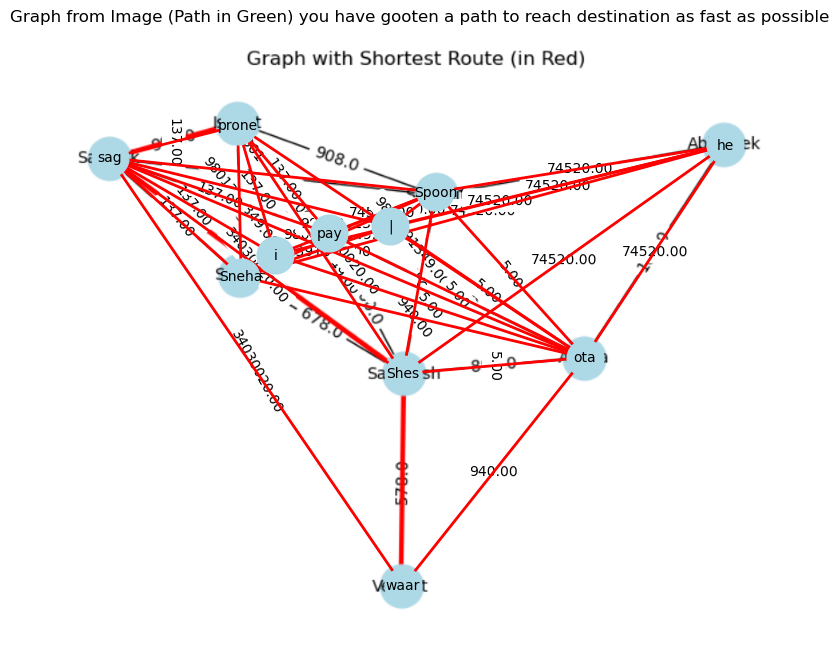

Enter source node from ['he', 'Shes', 'sag', 'Spoon', '|', 'ota', 'prone', 'Sneha', 'waar', 'i', 'pay']: he
Enter destination node from ['he', 'Shes', 'sag', 'Spoon', '|', 'ota', 'prone', 'Sneha', 'waar', 'i', 'pay']: sag
Shortest Path: he → | → sag
Total Cost: 74657.0
Time taken to reach Destination by vehicle  1244.2833333333333


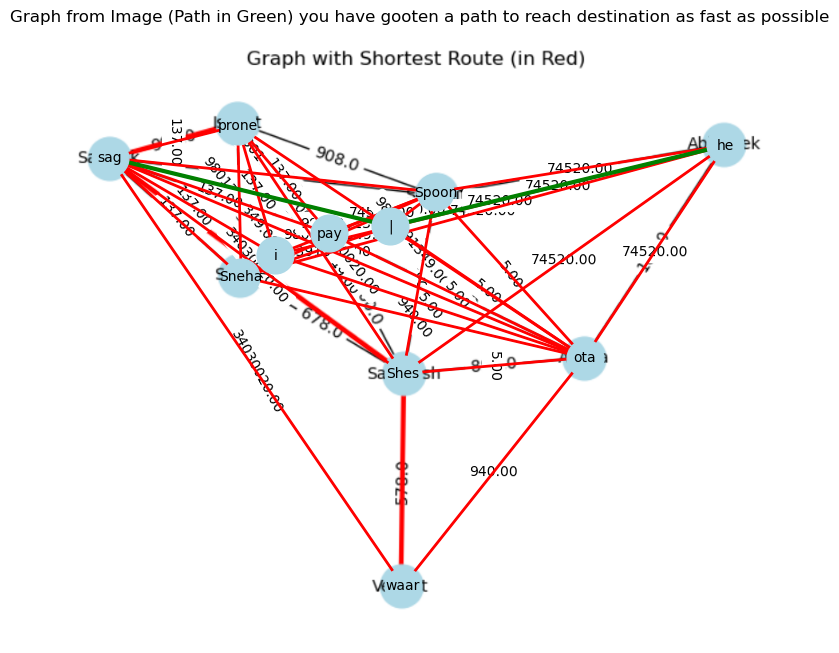

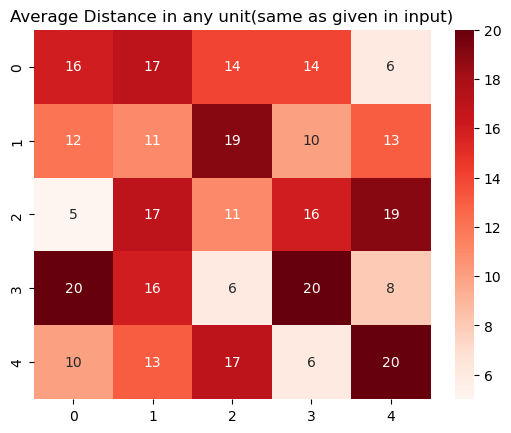

In [14]:
def main():
    print("Choose Mode:\n1. Manual City Graph (Taking user input)\n2. Smart Path (Taking image as input)")
    choice = input("Enter 1 or 2: ").strip()
    if choice == '1':
        G = build_graph_manually()
        print("\nNodes:", list(G.nodes))
# Function to draw a basic graph with optional path highlighting
        draw_graph_manual(G) #show
        source = input("Enter source node: ").strip()
        destination = input("Enter destination node: ").strip()
        path, cost = find_shortest_path(G, source, destination)
        if path:
            print("Shortest Path:", " → ".join(path))
            print("Total distace:", cost)
            print("Time taken to reach by vehicle " ,cost/60)
# Function to draw a basic graph with optional path highlighting
            draw_graph_manual(G, path)
        else:
            print("Could not find a valid path.")
        show_heatmap()

    elif choice == '2':
        image_path = input("Enter image path or URL: ").strip()
        G, nodes, image = build_graph_from_image(image_path)
        if not G:
            print("Failed to create graph from image")
            return
        print("\nDetected Nodes:", list(nodes.keys()))
# Function to overlay a graph on an image with an optional path
        draw_graph_image(G, nodes, image)
        if nodes:
            source = input(f"Enter source node from {list(nodes.keys())}: ").strip()
            destination = input(f"Enter destination node from {list(nodes.keys())}: ").strip()
            path, cost = find_shortest_path(G, source, destination)
            if path:
                print("Shortest Path:", " → ".join(path))
                print("Total Cost:", cost)
                print("Time taken to reach Destination by vehicle ", cost/60)
# Function to overlay a graph on an image with an optional path
                draw_graph_image(G, nodes, image, path)
            else:
                print("Could not find a valid path (please give a connected graph).")
        show_heatmap()

    else:
        print("Invalid choice. Exiting.")

if __name__ == "__main__":
    main()